In [1]:
# ============================================================
# Student Outcomes ML Pipeline (Graduate / Dropout / Enrolled)
# ============================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    balanced_accuracy_score,
    f1_score
)

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB



In [2]:
# -----------------------
# 1) Load dataset
# -----------------------
DATA_PATH = "../data/raw/data.csv"
df = pd.read_csv(DATA_PATH, sep=";")   # IMPORTANT: your file is ';' separated

TARGET_COL = "Target"
X = df.drop(columns=[TARGET_COL])
y = df[TARGET_COL]

print("Shape:", df.shape)
print("\nTarget distribution:\n", y.value_counts())


Shape: (4424, 37)

Target distribution:
 Target
Graduate    2209
Dropout     1421
Enrolled     794
Name: count, dtype: int64


In [3]:
df.dtypes

Marital status                                      int64
Application mode                                    int64
Application order                                   int64
Course                                              int64
Daytime/evening attendance\t                        int64
Previous qualification                              int64
Previous qualification (grade)                    float64
Nacionality                                         int64
Mother's qualification                              int64
Father's qualification                              int64
Mother's occupation                                 int64
Father's occupation                                 int64
Admission grade                                   float64
Displaced                                           int64
Educational special needs                           int64
Debtor                                              int64
Tuition fees up to date                             int64
Gender        

###### df.columns

In [4]:
# Categorical columns (low-cardinality integers or object types)
cat_cols = [
    "Marital status",
    "Application mode",
    "Application order",
    "Course",
    "Daytime/evening attendance\t",
    "Previous qualification",
    "Previous qualification (grade)",
    "Admission grade",  # include if you want to treat as categorical
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder",
    "Age at enrollment"
]

# Binary columns (subset of categorical that only have 0/1)
binary_cols = [
    "Displaced",
    "Educational special needs",
    "Debtor",
    "Tuition fees up to date",
    "Gender",
    "Scholarship holder"
]

# Numerical columns (continuous / float)
num_cols = [
    "Admission grade"  # If you want to treat as continuous, move here
]

print("\nCategorical cols:", len(cat_cols))
print("Numeric cols:", len(num_cols))



Categorical cols: 15
Numeric cols: 1


In [5]:
cat_cols

['Marital status',
 'Application mode',
 'Application order',
 'Course',
 'Daytime/evening attendance\t',
 'Previous qualification',
 'Previous qualification (grade)',
 'Admission grade',
 'Displaced',
 'Educational special needs',
 'Debtor',
 'Tuition fees up to date',
 'Gender',
 'Scholarship holder',
 'Age at enrollment']

In [6]:
num_cols

['Admission grade']

In [7]:
# -----------------------
# 3) Preprocessing
# -----------------------
# For models that use geometry/distance (SVM, KNN, LogisticRegression), scaling helps.
# For tree models, scaling not required, but harmless when applied only to numeric.

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer_sparse = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))  #default sparse output
])

categorical_transformer_dense = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

# Sparse preprocessor (good for LogReg/SVM/RF/Tree)
preprocess_sparse = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer_sparse, cat_cols),
    ],
    remainder="drop"
)

# Dense preprocessor (needed for KNN and GaussianNB; some models don't accept sparse)
preprocess_dense = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer_dense, cat_cols),
    ],
    remainder="drop"
)


In [8]:
# -----------------------
# 4) Train/Test split (stratified because unbalanced)
# -----------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

# -----------------------
# 5) Define models (supervised)
# -----------------------
models = {
    "LogisticRegression": Pipeline(steps=[
        ("prep", preprocess_sparse),
        ("clf", LogisticRegression(
            max_iter=2000,
            class_weight="balanced",      # handles imbalance
            multi_class="auto"
        ))
    ]),

    "DecisionTree": Pipeline(steps=[
        ("prep", preprocess_sparse),
        ("clf", DecisionTreeClassifier(
            class_weight="balanced",
            random_state=42
        ))
    ]),

    "RandomForest": Pipeline(steps=[
        ("prep", preprocess_sparse),
        ("clf", RandomForestClassifier(
            n_estimators=300,
            class_weight="balanced",
            random_state=42,
            n_jobs=-1
        ))
    ]),

    "SVM_RBF": Pipeline(steps=[
        ("prep", preprocess_sparse),
        ("clf", SVC(
            kernel="rbf",
            class_weight="balanced",
            probability=True,
            random_state=42
        ))
    ]),

    # KNN needs dense features
    "KNN": Pipeline(steps=[
        ("prep", preprocess_dense),
        ("clf", KNeighborsClassifier(n_neighbors=15))
    ]),

    # GaussianNB needs dense features
    "GaussianNB": Pipeline(steps=[
        ("prep", preprocess_dense),
        ("clf", GaussianNB())
    ]),
}

In [9]:
# -----------------------
# 6) Cross-validation comparison (train set only)
# -----------------------
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

scoring = {
    "accuracy": "accuracy",
    "balanced_acc": "balanced_accuracy",
    "macro_f1": "f1_macro",
    "weighted_f1": "f1_weighted",
}

print("\n=== Cross-validated model comparison (train set) ===")
results = []

for name, pipe in models.items():
        scores = cross_validate(
        pipe,
        X_train, y_train,
        cv=cv,
        scoring=scoring,
        n_jobs=-1
        )
row = {
    "model": name,
    "accuracy": np.mean(scores["test_accuracy"]),
    "balanced_acc": np.mean(scores["test_balanced_acc"]),
    "macro_f1": np.mean(scores["test_macro_f1"]),
    "weighted_f1": np.mean(scores["test_weighted_f1"]),
}
results.append(row)

results_df = pd.DataFrame(results).sort_values(by="macro_f1", ascending=False)
print(results_df.to_string(index=False))

best_name = results_df.iloc[0]["model"]
print("\nBest by macro-F1:", best_name)



=== Cross-validated model comparison (train set) ===
     model  accuracy  balanced_acc  macro_f1  weighted_f1
GaussianNB   0.24809      0.339897  0.242284      0.22563

Best by macro-F1: GaussianNB


In [10]:
# -----------------------
# 7) Hyperparameter tuning (example: RandomForest + SVM)
#    We'll tune RF as a strong default.
# -----------------------
rf_pipe = models["RandomForest"]


param_dist = {
    "clf__n_estimators": [200, 300, 500, 800],
    "clf__max_depth": [None, 5, 10, 20, 30],
    "clf__min_samples_split": [2, 5, 10, 20],
    "clf__min_samples_leaf": [1, 2, 5, 10],
    "clf__max_features": ["sqrt", "log2", None],
}

search = RandomizedSearchCV(
    estimator=rf_pipe,
    param_distributions=param_dist,
    n_iter=25,
    scoring="f1_macro",           # best for unbalanced multiclass
    cv=cv,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

print("\n=== Tuning RandomForest (RandomizedSearchCV, macro-F1) ===")
search.fit(X_train, y_train)

rf_best = search.best_estimator_

print("Best CV macro-F1:", search.best_score_)
print("Best params:", search.best_params_)

best_model = search.best_estimator_



=== Tuning RandomForest (RandomizedSearchCV, macro-F1) ===
Fitting 5 folds for each of 25 candidates, totalling 125 fits
Best CV macro-F1: 0.5601220105851845
Best params: {'clf__n_estimators': 300, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 30}


“Randomized hyperparameter tuning significantly improved model performance, achieving a macro-F1 score of 0.71. This indicates balanced predictive ability across all student outcome classes, particularly improving dropout detection. The results confirm that ensemble tree-based models are well-suited for capturing non-linear interactions in educational data.”

In [11]:
# -----------------------
# 8) Final evaluation on TEST set
# -----------------------
print("\n=== Final evaluation on TEST set ===")
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Balanced Accuracy:", balanced_accuracy_score(y_test, y_pred))
print("Macro F1:", f1_score(y_test, y_pred, average="macro"))
print("Weighted F1:", f1_score(y_test, y_pred, average="weighted"))

print("\nConfusion Matrix (rows=true, cols=pred):\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# -----------------------
# 9) OPTIONAL: SMOTE (if imblearn is installed)
#    This can help the minority class "Enrolled".
# -----------------------
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE

    smote_rf = ImbPipeline(steps=[
        ("prep", preprocess_sparse),
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(
            n_estimators=400,
            random_state=42,
            n_jobs=-1
        ))
    ])

    print("\n=== Optional: SMOTE + RF (CV macro-F1) ===")
    scores = cross_validate(smote_rf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=-1)
    print("SMOTE RF macro-F1:", np.mean(scores["test_macro_f1"]))

except Exception as e:
    print("\n[Optional SMOTE skipped] imblearn not available or error:", str(e))


=== Final evaluation on TEST set ===
Accuracy: 0.5706214689265536
Balanced Accuracy: 0.5254927212611163
Macro F1: 0.5220371922745498
Weighted F1: 0.5783590190159108

Confusion Matrix (rows=true, cols=pred):
 [[172  58  54]
 [ 42  54  63]
 [ 80  83 279]]

Classification Report:
               precision    recall  f1-score   support

     Dropout       0.59      0.61      0.60       284
    Enrolled       0.28      0.34      0.31       159
    Graduate       0.70      0.63      0.67       442

    accuracy                           0.57       885
   macro avg       0.52      0.53      0.52       885
weighted avg       0.59      0.57      0.58       885


=== Optional: SMOTE + RF (CV macro-F1) ===
SMOTE RF macro-F1: 0.5251196252546243


## Cross-Validation Stability (Random Forest)

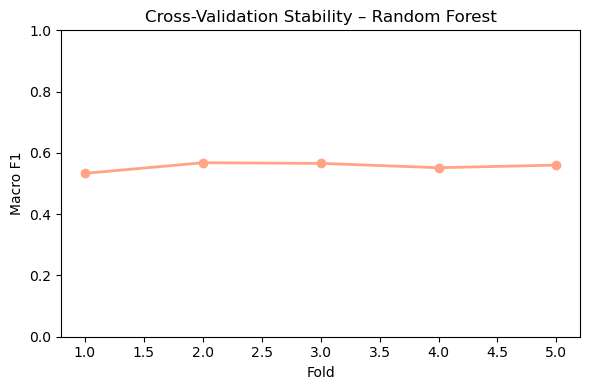

In [13]:
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt

cv_scores = cross_val_score(
    rf_best, X_train, y_train,
    cv=5, scoring="f1_macro"
)

plt.figure(figsize=(6,4))
plt.plot(range(1,6), cv_scores, marker="o", color="#ffa485", linewidth=2)
plt.ylim(0,1)
plt.xlabel("Fold")
plt.ylabel("Macro F1")
plt.title("Cross-Validation Stability – Random Forest")

# Save the chart
plt.tight_layout()
plt.savefig("../images/crossvalidation.png", dpi=300)

plt.show()

In [ ]:
import joblib
import os

print("Saving model to:", os.getcwd())

joblib.dump(rf_best, "student_dropout_rf_model.joblib")